In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('train_FD001.txt', sep=' ', header=None)

# dropping NAN values
df = df.dropna(axis=1, how='all')

# Naming the columns
df.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]
# # show dataframe
# df.head()



In [ ]:
# data preprocessing; removing unnecessary data
df.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df.head()


# MinMaxScaler
scaler = MinMaxScaler()
df.iloc[:,2:18] = scaler.fit_transform(df.iloc[:,2:18])

In [ ]:
# finding the max cycles of a unit which is used to find the Time to Failure (TTF)

df = pd.merge(df, df.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)

df['TTF'] = df['maxcycles'] - df['cycles']

# defining Fraction of Time to Failure (fTTF), where value of 1 denotes healthy engine and 0 denotes failure
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / (dat.TTF.max()-dat.TTF.min())

fTTFz = []
fTTF = []

for i in range(df['unit'].min(),df['unit'].max()+1):
    dat=df[df.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)

df['fTTF'] = fTTF
df

,unit,cycles,Op1,Op2,S2,S3,S4,S7,S8,S9,S11,S12,S13,S14,S15,S17,S20,S21,maxcycles,TTF,fTTF
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,192,191,1.000000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,192,190,0.994764
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,192,189,0.989529
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,192,188,0.984293
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,192,187,0.979058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,200,4,0.020101
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,200,3,0.015075
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,200,2,0.010050
20629,100,199,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,200,1,0.005025


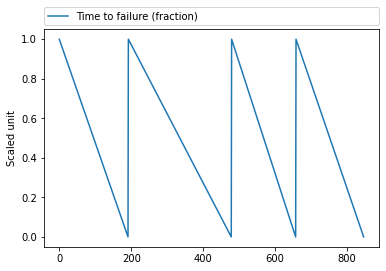

In [ ]:
cycles = df.groupby('unit', as_index=False)['cycles'].max()
mx = cycles.iloc[0:4,1].sum()

plt.plot(df.fTTF[0:mx])
plt.legend(['Time to failure (fraction)'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [ ]:
# splitting train and test data, test size 20%

# train set
df_train = df[(df.unit <= 80)]
X_train = df_train[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train[['fTTF']].values.ravel()

# test set
df_test = df[(df.unit > 80)]
X_test = df_test[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_test = df_test[['fTTF']].values.ravel()

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
model = Sequential()
model.add(Dense(50, input_dim=17, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
505/505 [==============================] - 1s 1ms/step - loss: 0.0453
Epoch 2/50
505/505 [==============================] - 1s 1ms/step - loss: 0.0058
Epoch 3/50
505/505 [==============================] - 1s 1ms/step - loss: 0.0051
Epoch 4/50
505/505 [==============================] - 1s 1ms/step - loss: 0.0049
Epoch 5/50
505/505 [==============================] - 0s 976us/step - loss: 0.0049
Epoch 6/50
505/505 [==============================] - 0s 924us/step - loss: 0.0046
Epoch 7/50
505/505 [==============================] - 0s 934us/step - loss: 0.0046
Epoch 8/50
505/505 [==============================] - 0s 926us/step - loss: 0.0045
Epoch 9/50
505/505 [==============================] - 0s 920us/step - loss: 0.0045
Epoch 10/50
505/505 [==============================] - 0s 956us/step - loss: 0.0045
Epoch 11/50
505/505 [==============================] - 0s 908us/step - loss: 0.0044
Epoch 12/50
505/505 [==============================] - 0s 931us/step - loss: 0.0043
Epoch 13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


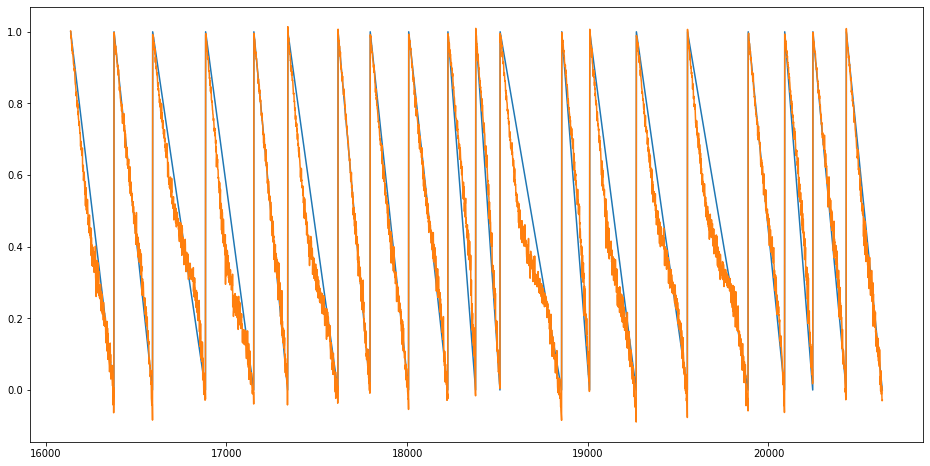

In [ ]:
score = model.predict(X_test) 
df_test['predicted'] = score

plt.figure(figsize = (16, 8)) 
plt.plot(df_test.fTTF) 
plt.plot(df_test.predicted)

In [ ]:
# RMSE
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

nn_rmse = sqrt(mean_squared_error(y_test, score))
print("RMSE: ", nn_rmse)

# r2 score
nn_r2 = r2_score(y_test, score)
print("r2 score: ", nn_r2)

df_test

RMSE:  0.07731335753561264
r2 score:  0.9289076835747075


,unit,cycles,Op1,Op2,S2,S3,S4,S7,S8,S9,S11,S12,S13,S14,S15,S17,S20,S21,maxcycles,TTF,fTTF,predicted
16138,81,1,0.212644,0.750000,0.250000,0.411380,0.411546,0.632850,0.303030,0.173921,0.404762,0.724947,0.235294,0.179792,0.464025,0.250000,0.565891,0.610743,240,239,1.000000,1.002260
16139,81,2,0.632184,0.666667,0.433735,0.331589,0.432647,0.619968,0.287879,0.191107,0.321429,0.720682,0.279412,0.208639,0.509427,0.333333,0.596899,0.622756,240,238,0.995816,1.001822
16140,81,3,0.471264,0.916667,0.403614,0.335295,0.238859,0.552335,0.318182,0.165709,0.321429,0.507463,0.264706,0.205439,0.489804,0.500000,0.697674,0.644573,240,237,0.991632,0.982558
16141,81,4,0.494253,0.500000,0.361446,0.519948,0.381668,0.708535,0.212121,0.156197,0.440476,0.637527,0.235294,0.227991,0.444017,0.333333,0.488372,0.726871,240,236,0.987448,0.988691
16142,81,5,0.637931,0.666667,0.662651,0.424024,0.461344,0.587762,0.212121,0.164857,0.232143,0.592751,0.352941,0.202652,0.277799,0.333333,0.697674,0.603286,240,235,0.983264,0.975222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,200,4,0.020101,0.011829
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,200,3,0.015075,0.003827
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,200,2,0.010050,-0.021300
20629,100,199,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,200,1,0.005025,-0.030051


In [ ]:
def totcycles(data):
    return(data['cycles'] / (1-data['predicted']))
    
df_test['maxpredcycles'] = totcycles(df_test)

df_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,unit,cycles,Op1,Op2,S2,S3,S4,S7,S8,S9,S11,S12,S13,S14,S15,S17,S20,S21,maxcycles,TTF,fTTF,predicted,maxpredcycles
16138,81,1,0.212644,0.750000,0.250000,0.411380,0.411546,0.632850,0.303030,0.173921,0.404762,0.724947,0.235294,0.179792,0.464025,0.250000,0.565891,0.610743,240,239,1.000000,1.002260,-442.507148
16139,81,2,0.632184,0.666667,0.433735,0.331589,0.432647,0.619968,0.287879,0.191107,0.321429,0.720682,0.279412,0.208639,0.509427,0.333333,0.596899,0.622756,240,238,0.995816,1.001822,-1097.985340
16140,81,3,0.471264,0.916667,0.403614,0.335295,0.238859,0.552335,0.318182,0.165709,0.321429,0.507463,0.264706,0.205439,0.489804,0.500000,0.697674,0.644573,240,237,0.991632,0.982558,172.003445
16141,81,4,0.494253,0.500000,0.361446,0.519948,0.381668,0.708535,0.212121,0.156197,0.440476,0.637527,0.235294,0.227991,0.444017,0.333333,0.488372,0.726871,240,236,0.987448,0.988691,353.707184
16142,81,5,0.637931,0.666667,0.662651,0.424024,0.461344,0.587762,0.212121,0.164857,0.232143,0.592751,0.352941,0.202652,0.277799,0.333333,0.697674,0.603286,240,235,0.983264,0.975222,201.791843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.782917,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,200,4,0.020101,0.011829,198.346241
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.866475,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,200,3,0.015075,0.003827,197.756893
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.775321,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,200,2,0.010050,-0.021300,193.870520
20629,100,199,0.436782,0.750000,0.608434,0.746021,0.747468,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,200,1,0.005025,-0.030051,193.194274


In [ ]:
from google.colab import drive
drive.mount('/drive')
df_test.to_csv('/drive/My Drive/test_dataframe.csv') # export dataframe to google drive as as csv file to analyse the findings

Mounted at /drive


In [ ]:
# upon observation it is noticed that the prediction gets more accurate the further the cycle is in the time series

# df_test.groupby('unit', as_index=False)['maxpredcycles'].quantile(.10) // pd.groupby().quantile() to get the quantile result
# df_test.groupby('unit', as_index=False)['cycles'].max()

dff = pd.merge(df_test.groupby('unit', as_index=False)['maxpredcycles'].quantile(.72), df.groupby('unit', as_index=False)['maxcycles'].max(), how='left', on='unit')
dff # display the preliminary results for obervation


,unit,maxpredcycles,maxcycles
0,81,227.410689,240
1,82,223.983337,214
2,83,302.622574,293
3,84,243.424250,267
4,85,194.721151,188
5,86,260.806457,278
6,87,185.547065,178
7,88,208.090861,213
8,89,224.634721,217
9,90,202.965297,154


In [ ]:
MAXPRED = dff.maxpredcycles
MAXI = dff.maxcycles 

dff_rmse = sqrt(mean_squared_error(MAXPRED, MAXI))
print("RMSE: ", dff_rmse)


RMSE:  21.84978831316669
